In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
DATA_FOLDER="data_final/"

# Reading Data 

### Прочитаем данные

In [3]:
transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
smpsb_df = pd.read_csv(os.path.join(
    DATA_FOLDER,
    "sample_submission.csv.gz"),
    header=0, sep=',', quotechar='"')

In [4]:
test_df = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

In [5]:
transactions.date=pd.to_datetime(transactions.date,format='%d.%m.%Y')
transactions['day']= transactions.date.dt.day
transactions['month'] = transactions.date.dt.month
transactions['year'] = transactions.date.dt.year

## Preprocessing data 

### add categories

In [6]:
l = list(item_categories.item_category_name)
l_cat = l

for ind in range(0,8):
    l_cat[ind] = 'Access'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'

for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'

for ind in range(26,28):
    l_cat[ind] = 'Phone games'

for ind in range(28,32):
    l_cat[ind] = 'CD games'

for ind in range(32,37):
    l_cat[ind] = 'Card'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'

for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Gifts'

for ind in range(73,79):
    l_cat[ind] = 'Soft'


item_categories['cat'] = l_cat
item_categories.head()

,item_category_name,item_category_id,cat
0,PC - Гарнитуры/Наушники,0,Access
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


### add location

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

## Embedding 

In [9]:
import gensim.models
import fasttext

# items.item_name.to_csv("data.txt",encoding="utf-8")
model = fasttext.skipgram('data.txt', 'model1',dim=100,minn=2,maxn=5)

model1 = gensim.models.FastText.load_fasttext_format("model1.bin")



In [10]:
model1.wv.vector_size

100

In [11]:
def avg_feature_vector(sentence, model):
    words = sentence.split()
    feature_vec = np.zeros((model.vector_size, ), dtype='float32')
    n_words = 0
    for word in words:
        feature_vec = np.add(feature_vec, model[word])
    feature_vec = np.divide(feature_vec, len(words))
    return feature_vec

In [12]:
items_name = items['item_name'].values

In [13]:
A=np.array(list(map(lambda x: avg_feature_vector(x,model1.wv),items_name)))

##  EDA

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [15]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013


In [16]:
item_categories.head()

,item_category_name,item_category_id,cat
0,PC - Гарнитуры/Наушники,0,Access
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


In [17]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [18]:
shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


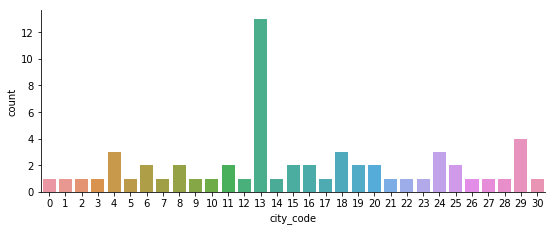

In [19]:
# _, ax = plt.subplots(figsize=(10,4))
fig=sns.catplot(x="city_code",kind="count",data=shops)
fig.fig.set_size_inches(8,3)

In [20]:
cat_by_iid=items.merge(item_categories,on='item_category_id')[['item_id','cat']]

In [21]:
cat_by_iid['cat_code'] = LabelEncoder().fit_transform(cat_by_iid['cat'])

In [22]:
trans_with_cat=transactions.merge(cat_by_iid,on='item_id')

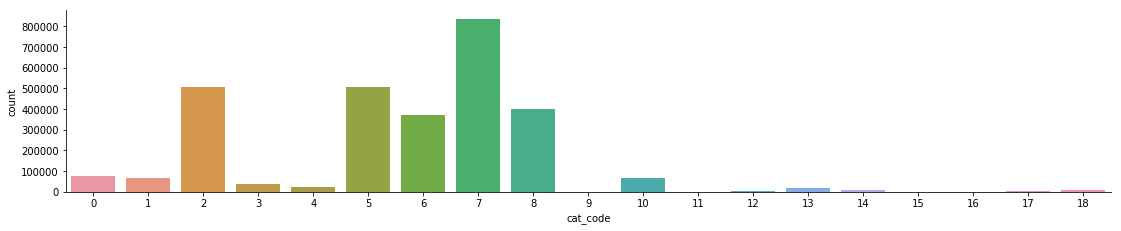

In [23]:
fig=sns.catplot(x="cat_code",kind="count",data=trans_with_cat)
fig.fig.set_size_inches(18,3)

In [24]:
cat_by_iid[['cat',	'cat_code']].drop_duplicates()

,cat,cat_code
0,Movie,7
5035,Soft,10
5368,Music,8
7733,Consoles Games,5
8361,CD games,2
12157,Books,1
16674,Gifts,6
18438,Card,3
18739,Игры - Аксессуары для игр,13
19545,Access,0


In [25]:
trans_with_cat

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,cat,cat_code
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,Movie,7
1,2013-01-23,0,24,22154,999.00,1.0,23,1,2013,Movie,7
2,2013-01-20,0,27,22154,999.00,1.0,20,1,2013,Movie,7
3,2013-01-02,0,25,22154,999.00,1.0,2,1,2013,Movie,7
4,2013-01-03,0,25,22154,999.00,1.0,3,1,2013,Movie,7
5,2013-01-20,0,25,22154,999.00,1.0,20,1,2013,Movie,7
6,2013-01-23,0,25,22154,999.00,1.0,23,1,2013,Movie,7
7,2013-01-26,0,25,22154,999.00,1.0,26,1,2013,Movie,7
8,2013-01-27,0,6,22154,999.00,1.0,27,1,2013,Movie,7
9,2013-01-10,0,15,22154,999.00,1.0,10,1,2013,Movie,7


In [26]:
agg_by_mount_trans = trans_with_cat.groupby(['shop_id','cat_code']).agg({'item_cnt_day':np.sum}).reset_index()

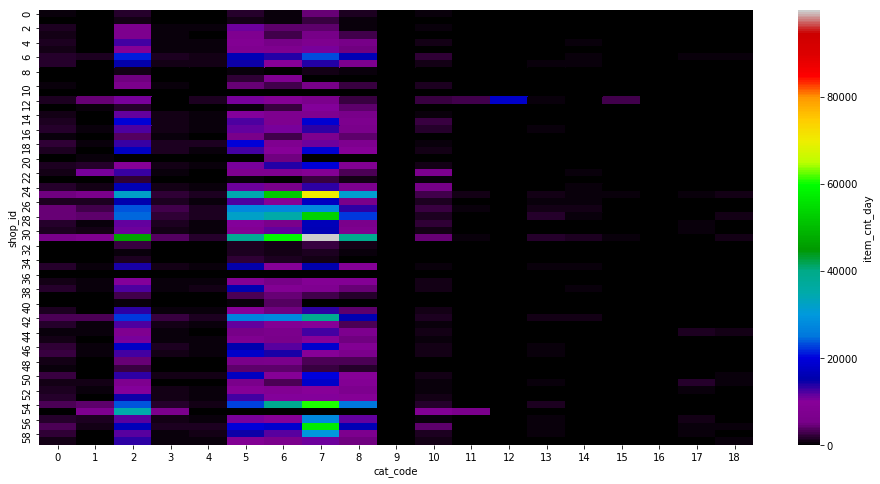

In [27]:
stores_hm = agg_by_mount_trans.pivot_table(index='shop_id',
                                           columns='cat_code',
                                           values='item_cnt_day', aggfunc=np.sum, fill_value=0)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_day'});

## Aggregate_data 

In [28]:
from itertools import product
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [29]:
train_df = transactions.groupby(['date_block_num','shop_id','item_id']).agg(
    {'item_cnt_day': np.sum, 'item_price': np.mean}).reset_index()

In [30]:
train_df=train_df.rename(columns={'item_cnt_day': 'item_cnt_month'})

####  add_cat type

In [31]:
items=items.merge(item_categories,on=['item_category_id'])
items['cat_id']= LabelEncoder().fit_transform(items['cat'])

In [32]:
train_df = train_df.merge(items,on=['item_id'])
test_df = test_df.merge(items,on=['item_id'])

#### add city 

In [33]:
train_df=train_df.merge(shops[['shop_id','city']],on=['shop_id'])
test_df = test_df.merge(shops[['shop_id','city']],on=['shop_id'])

### mean_encoding 

In [34]:
for type_ids in [['item_id'], ['shop_id'], ['cat_id'], ['item_id', 'shop_id']]:
    for column_id in ['item_price', 'item_cnt_month']:
        mean_df = train_df[type_ids + [column_id]].groupby(type_ids).agg(np.mean).reset_index()
        mean_df.rename(columns={column_id: "mean_of_"+column_id+"_groupby_"+"_".join(type_ids)},
             inplace=True
        )
        
        train_df = pd.merge(train_df, mean_df, on=type_ids, how='left')
        test_df = pd.merge(test_df, mean_df, on=type_ids, how='left')

In [35]:
train_df.to_csv(os.path.join(DATA_FOLDER, 'train_df1.csv'))
test_df.to_csv(os.path.join(DATA_FOLDER, 'test_df1.csv'))

In [38]:
w=test_df[test_df['mean_of_item_price_groupby_item_id'].isnull()]

In [39]:
test_df.keys()

Index(['ID', 'shop_id', 'item_id', 'item_name', 'item_category_id',
       'item_category_name', 'cat', 'cat_id', 'city',
       'mean_of_item_price_groupby_item_id',
       'mean_of_item_cnt_month_groupby_item_id',
       'mean_of_item_price_groupby_shop_id',
       'mean_of_item_cnt_month_groupby_shop_id',
       'mean_of_item_price_groupby_cat_id',
       'mean_of_item_cnt_month_groupby_cat_id',
       'mean_of_item_price_groupby_item_id_shop_id',
       'mean_of_item_cnt_month_groupby_item_id_shop_id'],
      dtype='object')

### fillna 

In [40]:
test_df['mean_of_item_price_groupby_item_id'] = test_df['mean_of_item_price_groupby_item_id'].fillna(test_df['mean_of_item_price_groupby_cat_id'])
test_df['mean_of_item_cnt_month_groupby_item_id'] = test_df['mean_of_item_cnt_month_groupby_item_id'].fillna(test_df['mean_of_item_cnt_month_groupby_cat_id'])
test_df['mean_of_item_price_groupby_item_id_shop_id'] = test_df['mean_of_item_price_groupby_item_id_shop_id'].fillna(test_df['mean_of_item_price_groupby_item_id'])
test_df['mean_of_item_cnt_month_groupby_item_id_shop_id'] = test_df['mean_of_item_cnt_month_groupby_item_id_shop_id'].fillna(test_df['mean_of_item_cnt_month_groupby_item_id'])

In [41]:
train_df['mean_of_item_price_groupby_item_id_shop_id'] = train_df['mean_of_item_price_groupby_item_id_shop_id'].fillna(train_df['mean_of_item_price_groupby_item_id'])
train_df['mean_of_item_cnt_month_groupby_item_id_shop_id'] = train_df['mean_of_item_cnt_month_groupby_item_id_shop_id'].fillna(train_df['mean_of_item_cnt_month_groupby_item_id'])

In [42]:
for df in train_df, test_df:
    for feat in train_df.columns[6:]:
        if 'item_cnt' in feat:
            df[feat]=df[feat].fillna(0)
        elif 'item_price' in feat:
            df[feat]=df[feat].fillna(df[feat].median())

## Time_series

In [43]:
train_df_all = train_df.copy()
train_df = train_df[train_df['date_block_num']>=12]

In [44]:
train_df.keys()

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price',
       'item_name', 'item_category_id', 'item_category_name', 'cat', 'cat_id',
       'city', 'mean_of_item_price_groupby_item_id',
       'mean_of_item_cnt_month_groupby_item_id',
       'mean_of_item_price_groupby_shop_id',
       'mean_of_item_cnt_month_groupby_shop_id',
       'mean_of_item_price_groupby_cat_id',
       'mean_of_item_cnt_month_groupby_cat_id',
       'mean_of_item_price_groupby_item_id_shop_id',
       'mean_of_item_cnt_month_groupby_item_id_shop_id'],
      dtype='object')